
## 04 Modeling
**Objetivo**: Construir y evaluar modelos de clasificación.
**Contenido**:

- Carga y preparación de los datos
- División de los datos en conjuntos de entrenamiento y prueba
- Entrenamiento de modelos
- Evaluación de los modelos
- Comparación de resultados

In [1]:
##  Importación de Librerías
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler


import matplotlib.pyplot as plt
import seaborn as sns

## Carga y Preparación de los Datos

In [2]:

dir_data_processed = '../data/processed'
ruta_archivo_X = os.path.join(dir_data_processed, 'datos_procesados.csv')
X = pd.read_csv(ruta_archivo_X)

ruta_archivo_y = os.path.join(dir_data_processed, 'target.csv')
y = pd.read_csv(ruta_archivo_y )


In [3]:
X.shape , y.shape

((432668, 21), (432668, 1))

## División de los Datos en Conjuntos de Entrenamiento y Prueba

### Criterios para la División de Datos

#### Entrenamiento (Training Set):
- Representa el 70% del conjunto de datos.
- Se utiliza para ajustar el modelo.

#### Validación (Validation Set):
- Representa el 15% del conjunto de datos.
- Se utiliza para ajustar los hiperparámetros y prevenir el sobreajuste.

#### Prueba (Test Set):
- Representa el 15% del conjunto de datos.
- Se utiliza para evaluar el rendimiento final del modelo.


In [4]:
# Dividir los datos en conjunto de entrenamiento y conjunto temporal (que se dividirá en validación y prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el conjunto temporal en conjunto de validación y conjunto de prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Mostrar las formas de los conjuntos de datos para asegurarse de que la división se realizó correctamente
print("Forma del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Forma del conjunto de validación:", X_val.shape, y_val.shape)
print("Forma del conjunto de prueba:", X_test.shape, y_test.shape)


Forma del conjunto de entrenamiento: (302867, 21) (302867, 1)
Forma del conjunto de validación: (64900, 21) (64900, 1)
Forma del conjunto de prueba: (64901, 21) (64901, 1)


## Balancear Datos aplicar Submuestreo (Undersampling)

In [5]:
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Mostrar la distribución de clases después del submuestreo
X_train_resampled.shape,y_train_resampled.shape

((14604, 21), (14604, 1))

In [6]:
y_train_resampled.value_counts()

isFraud
0          7302
1          7302
Name: count, dtype: int64

## Entrenamiento de Modelos

###  Modelo de Regresión Logística

In [7]:
# Entrenar el modelo
log_reg = LogisticRegression()
log_reg.fit(X_train_resampled, y_train_resampled)

# Predicciones y evaluación
y_pred_log_reg = log_reg.predict(X_val)
print('Logistic Regression Accuracy:', accuracy_score(y_val, y_pred_log_reg))
print('ROC AUC Score:', roc_auc_score(y_val, y_pred_log_reg))


/home/joseph/Documents/proyecto-portafolio/deteccion_fraude/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy: 0.7015562403697997
ROC AUC Score: 0.5803934130394423


### Modelo de Bosque Aleatorio

In [8]:
# Entrenar el modelo
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# Predicciones y evaluación
y_pred_rf = rf_clf.predict(X_val)
print('Random Forest Accuracy:', accuracy_score(y_val, y_pred_rf))
print('ROC AUC Score:', roc_auc_score(y_val, y_pred_rf))


/home/joseph/Documents/proyecto-portafolio/deteccion_fraude/venv/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Accuracy: 0.7187827426810478
ROC AUC Score: 0.7442118841237731


## Evaluación de los Modelos

Logistic Regression Classification Report:


              precision    recall  f1-score   support

           0       0.98      0.71      0.82     63324
           1       0.04      0.45      0.07      1576

    accuracy                           0.70     64900
   macro avg       0.51      0.58      0.45     64900
weighted avg       0.96      0.70      0.80     64900



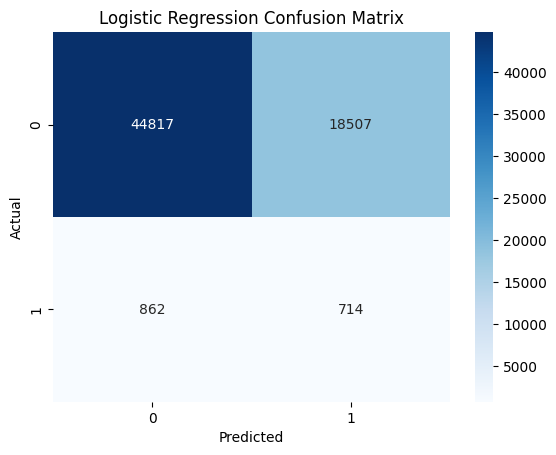

In [9]:
# Reporte de clasificación
print('Logistic Regression Classification Report:')
print(classification_report(y_val, y_pred_log_reg))

# Matriz de confusión
conf_matrix_log_reg = confusion_matrix(y_val, y_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Evaluación del Modelo de Bosque Aleatorio

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83     63324
           1       0.06      0.77      0.12      1576

    accuracy                           0.72     64900
   macro avg       0.53      0.74      0.48     64900
weighted avg       0.97      0.72      0.82     64900



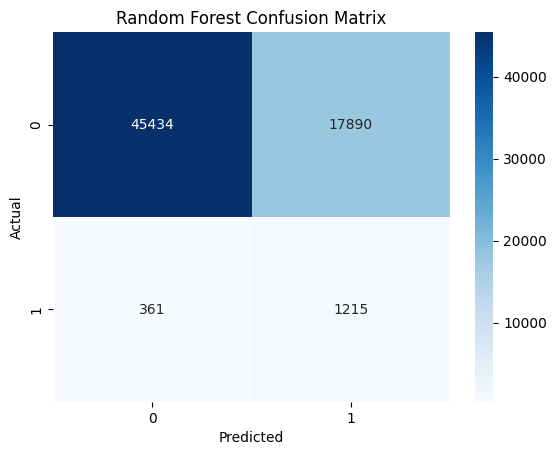

In [10]:
# Reporte de clasificación
print('Random Forest Classification Report:')
print(classification_report(y_val, y_pred_rf))

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Comparación de Resultados

                 Model  Accuracy  ROC AUC Score
0  Logistic Regression  0.701556       0.580393
1        Random Forest  0.718783       0.744212


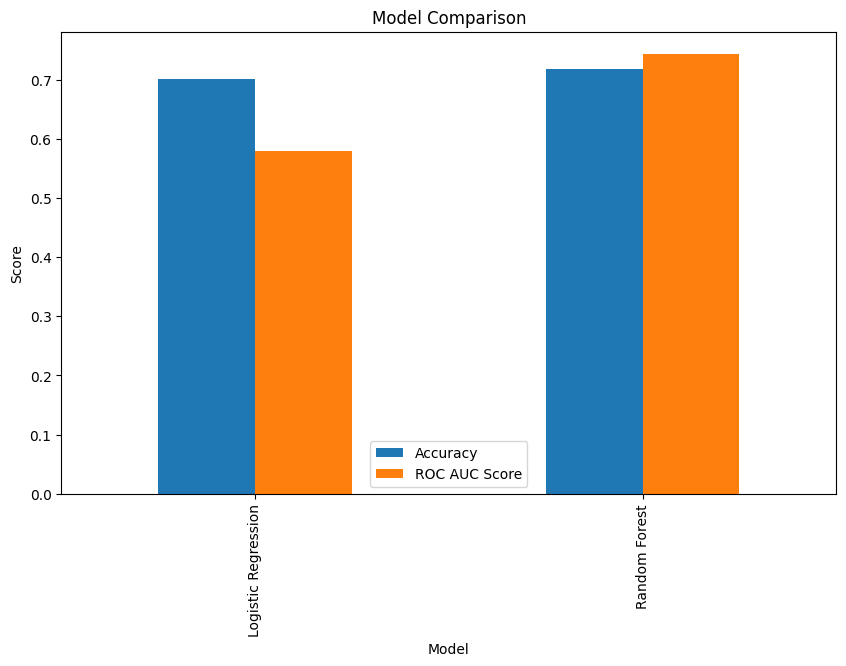

In [11]:
# Comparación de métricas
models = ['Logistic Regression', 'Random Forest']
accuracy = [accuracy_score(y_val, y_pred_log_reg), accuracy_score(y_val, y_pred_rf)]
roc_auc = [roc_auc_score(y_val, y_pred_log_reg), roc_auc_score(y_val, y_pred_rf)]

comparison_df = pd.DataFrame({'Model': models, 'Accuracy': accuracy, 'ROC AUC Score': roc_auc})
print(comparison_df)

# Visualización de la comparación
comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.show()
